<a href="https://colab.research.google.com/github/befozg/AM_entrance/blob/main/classification_multi_lablel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Краткий отчет

Решение задачи можно разбить на 2 больших блока:

1) Предобработка данных

В данных есть много пропусков и категориальных признаков. Выкидываю столбцы, которые полностью NaN, и у которых мало значений не NaN. Далее было необходимо заполнить пропуски(заполнял средним по столбцу) и закодировать эти признаки. Принял решение кодировать LabelEncoder-ом, так как NaN-ов сильно много, и количественные методы (CountEncoding) дали бы сильно большие числа, что потом плохо могло бы повлиять на сходимость. Разделяя категориальные и непрерывные фичи, из непрерывных отобрал фичи с высокой попарной корреляцией. Далее обучил base_classifier - тут это logregression и xgboost-classifier. Так как категориальных фичей мнеого, ожидал что бустинг на деревьях сработает лучше. 
Сначало запускал на данном этапе обычные базовые классификаторы и отобрал фичи которые вносят вклад. Потом на выбранном пространстве признаков обучал модели с беггингом и семплингом на базе этих классификаторов.

2) Подходов несколько при multi-label задаче предсказания.

Первый подход - мы делаем предположение, что эти таргеты независимы, строим классификаторы для каждого таргета отдельно и обучаем их. Такой подход не всегда сработает хорошо, так как таргеты могут быть зависимы.

Второй подход - каждому набору  $\{0,1\}^{14}$  ->  $class_i$ , но тут такой подход плох тем, что классов будет в худшем случае  $2^{14}$ , что очень много.

В качестве модели тестировал ансамбль логрегрессий с беггингом (решающим деревом, xgboost-classifier-ом) и оверсемплингом, также тестировал нейросетку с и без lstm блока для сравнения. Ожидаемо хороший результат показал ансамбль, так как нейросетка из-за высокого имбаланса в данных сильно переобучалась негативные объекты. Конкретные метрики указаны в ноутбуке далее. При обучении использовал кросс-валидацию (в целом common practice).

После обучения моделей также смотрел вклады признаков дабы выкинуть совсем бесполезные. Делал экспериментов достаточно, но изначально предполагаемый беггинг с логрегрессиями/бустингом и sampling-ом дал лучший результат.

Чтобы избегать загромождений, некоторые поиски хороших параметров я убрал, оставляя уже найденные лучшие.


## Установка пакетов

In [1]:
!pip install scikit-multilearn
!pip install category_encoders
!pip install seaborn
!pip install xgboost

     |████████████████████████████████| 92kB 3.6MB/s 
     |████████████████████████████████| 81kB 3.3MB/s 


## Предобработка

In [285]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import scipy as sp
import numpy as np
import warnings
from category_encoders import CountEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from sklearn.cross_decomposition import CCA
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import FactorAnalysis

In [286]:
train_data_path='problem_train.csv'
test_data_path='problem_test.csv'
train_labels_path='problem_labels.csv'
test_labels_path='problem_test_labels.csv'

Подгрузка табличных данных:

In [287]:
def load_data():
  train_data = pd.read_csv(train_data_path)
  train_labels = pd.read_csv(train_labels_path)
  test_data = pd.read_csv(test_data_path)
  return train_data, train_labels, test_data

train_data, train_labels, test_data = load_data()
train_data.head()

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,n_0008,n_0009,n_0010,n_0011,n_0012,n_0013,n_0014,n_0015,n_0016,n_0017,n_0018,n_0019,n_0020,n_0021,n_0022,n_0023,n_0024,n_0025,n_0026,n_0027,n_0028,n_0029,n_0030,n_0031,n_0032,n_0033,n_0034,n_0035,n_0036,n_0037,...,c_1338,c_1339,c_1340,c_1341,c_1342,c_1343,c_1344,c_1345,c_1346,c_1347,c_1348,c_1349,c_1350,c_1351,c_1352,c_1353,c_1354,c_1355,c_1356,c_1357,c_1358,c_1359,c_1360,c_1361,c_1362,c_1363,c_1364,c_1365,c_1366,c_1367,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,NaN,NaN,NaN,NaN,0.292683,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223881,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,NaN,NaN,NaN,NaN,0.243902,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.472727,NaN,NaN,NaN,NaN,0.104478,0.125,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,b,NaN,j,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,b,NaN,b,NaN,NaN,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,NaN,NaN,NaN,NaN,0.304878,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527273,NaN,NaN,NaN,NaN,0.119403,0.250,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c,NaN,a,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,NaN,NaN,NaN,NaN,0.207317,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149254,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,a,NaN,j,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN,NaN,g,NaN,a,NaN,b,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,NaN,NaN,NaN,NaN,0.219512,NaN,NaN,NaN,NaN,0.388889,NaN,0.0,NaN,0.666667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.072727,NaN,NaN,NaN,NaN,0.074627,NaN,NaN,0.0025,...,NaN,NaN,NaN,a,NaN,b,NaN,j,NaN,d,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e,NaN,b,b,b,NaN,NaN,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN


Выкинем сразу столбец id

In [288]:
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
train_labels.drop("id", axis=1, inplace=True)

In [289]:
train_labels.head()

,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,0,0,0,1,1,0,0,0,0,0,1,1,1,0


На самом деле подходов несколько при multi-label задаче предсказания. 

Первый подход - мы делаем предположение, что эти таргеты независимы, строим классификаторы для каждого таргета отдельно и обучаем их. Такой подход не всегда сработает хорошо, так как таргеты могут быть зависимы.

Второй подход - каждому набору $\{0,1\}^{14}$ -> $class_i$, но тут такой подход плох тем, что классов будет в худшем случае $2^{14}$, что очень много.

In [290]:
nan_cols = [i for i in train_data.columns if train_data[i].isnull().all()]
train_data.drop(nan_cols, axis=1, inplace=True)
test_data.drop(nan_cols, axis=1, inplace=True)

In [291]:
part_nan_cols = np.array([i for i in train_data.columns if np.sum(train_data[i].isnull()) > 7800])
train_data.drop(part_nan_cols, axis=1, inplace=True)
test_data.drop(part_nan_cols, axis=1, inplace=True)

In [292]:
train_data.head()

,release,n_0001,n_0002,n_0005,n_0006,n_0007,n_0012,n_0014,n_0015,n_0016,n_0017,n_0019,n_0020,n_0022,n_0025,n_0027,n_0028,n_0029,n_0030,n_0034,n_0035,n_0037,n_0038,n_0039,n_0041,n_0046,n_0047,n_0048,n_0050,n_0051,n_0052,n_0054,n_0057,n_0059,n_0060,n_0061,n_0064,n_0066,n_0067,n_0068,...,c_1289,c_1296,c_1297,c_1302,c_1306,c_1309,c_1311,c_1313,c_1314,c_1316,c_1320,c_1323,c_1325,c_1326,c_1327,c_1328,c_1330,c_1333,c_1335,c_1337,c_1338,c_1341,c_1343,c_1345,c_1347,c_1348,c_1352,c_1354,c_1355,c_1361,c_1363,c_1364,c_1365,c_1366,c_1370,c_1372,c_1373,c_1374,c_1375,c_1377
0,a,NaN,0.025449,0.368421,NaN,NaN,0.292683,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223881,NaN,NaN,0.193548,NaN,NaN,NaN,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,0.00,NaN,0.928571,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,g,NaN,b,a,e,w,NaN,NaN,NaN,b,NaN,NaN,b,NaN,NaN,NaN,e,b,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN
1,a,NaN,0.031297,0.315789,NaN,NaN,0.243902,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.472727,NaN,0.104478,0.125,NaN,0.177419,NaN,0.000000,NaN,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,0.00,NaN,0.928571,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,b,a,NaN,a,s,NaN,b,a,e,q,NaN,NaN,NaN,b,j,NaN,b,NaN,NaN,NaN,e,b,NaN,b,NaN,a,a,NaN,NaN,NaN,NaN
2,a,NaN,0.024475,0.342105,NaN,NaN,0.304878,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.527273,NaN,0.119403,0.250,NaN,0.290323,NaN,0.181818,NaN,1,0.818182,1,NaN,1,NaN,NaN,NaN,NaN,1,0.02,NaN,0.428571,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,t,NaN,a,b,e,u,NaN,NaN,NaN,a,NaN,NaN,b,NaN,NaN,NaN,c,a,NaN,NaN,NaN,a,a,NaN,b,NaN,NaN
3,a,NaN,0.041694,0.447368,NaN,NaN,0.207317,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149254,NaN,NaN,0.370968,NaN,0.090909,NaN,1,NaN,1,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,0.571429,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,g,NaN,b,b,NaN,w,NaN,NaN,NaN,a,j,NaN,b,NaN,a,NaN,g,a,NaN,b,NaN,NaN,a,NaN,NaN,NaN,NaN
4,c,NaN,0.038120,0.315789,NaN,NaN,0.219512,NaN,NaN,NaN,0.388889,0.0,NaN,NaN,0.0,NaN,NaN,0.072727,NaN,0.074627,NaN,0.0025,0.177419,0.3125,0.000000,NaN,1,0.181818,1,0.05,1,NaN,NaN,0.2,0.030303,1,0.00,0.183673,0.928571,NaN,...,NaN,NaN,b,d,a,NaN,NaN,b,NaN,b,a,b,NaN,w,NaN,a,a,e,b,NaN,NaN,a,b,j,d,b,NaN,NaN,NaN,e,b,b,b,NaN,b,a,NaN,a,NaN,NaN


In [293]:
categorical_features_df = train_data.select_dtypes(include='object')
categorical_features_list = np.array(categorical_features_df.columns)
continous_features_df = train_data.select_dtypes(exclude='object')
continous_features_list = np.array(continous_features_df.columns)
print("Categorical features: ", len(categorical_features_list))
print("Continous features: ", len(continous_features_list))

Categorical features:  528
Continous features:  161


Закодируем категориальные фичи и заполним пропуски в данных. В данном подходе в категориальных фичах NaN будет считаться как отдельная категория.

In [294]:
def encode_str_columns(data, categorical_features_list):
  for column in categorical_features_list:
      data[column] = LabelEncoder().fit_transform(data[column].astype('str'))
  return data

In [295]:
# train_data.d()
train_data = encode_str_columns(train_data, categorical_features_list)
test_data = encode_str_columns(test_data, categorical_features_list)

In [296]:
test_data[continous_features_list] = test_data[continous_features_list].fillna(test_data.median())

In [297]:
train_data[continous_features_list] = train_data[continous_features_list].fillna(train_data.median())
train_data.head()

,release,n_0001,n_0002,n_0005,n_0006,n_0007,n_0012,n_0014,n_0015,n_0016,n_0017,n_0019,n_0020,n_0022,n_0025,n_0027,n_0028,n_0029,n_0030,n_0034,n_0035,n_0037,n_0038,n_0039,n_0041,n_0046,n_0047,n_0048,n_0050,n_0051,n_0052,n_0054,n_0057,n_0059,n_0060,n_0061,n_0064,n_0066,n_0067,n_0068,...,c_1289,c_1296,c_1297,c_1302,c_1306,c_1309,c_1311,c_1313,c_1314,c_1316,c_1320,c_1323,c_1325,c_1326,c_1327,c_1328,c_1330,c_1333,c_1335,c_1337,c_1338,c_1341,c_1343,c_1345,c_1347,c_1348,c_1352,c_1354,c_1355,c_1361,c_1363,c_1364,c_1365,c_1366,c_1370,c_1372,c_1373,c_1374,c_1375,c_1377
0,0,0.702381,0.025449,0.368421,0.2,0.0,0.292683,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.254545,0.185185,0.223881,0.125,0.0025,0.193548,0.208333,0.090909,0.418605,1,0.727273,1,0.05,1,0.0,0.042553,0.0,0.000000,1,0.00,0.081633,0.928571,0.259259,...,13,2,2,4,2,5,6,11,2,1,2,2,2,5,12,1,0,4,21,7,2,2,1,11,6,1,2,10,2,4,1,4,2,6,3,0,5,17,13,2
1,0,0.702381,0.031297,0.315789,0.2,0.0,0.243902,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.472727,0.185185,0.104478,0.125,0.0025,0.177419,0.208333,0.000000,0.418605,1,0.727273,1,0.05,1,0.0,0.042553,0.0,0.000000,1,0.00,0.081633,0.928571,0.259259,...,13,2,2,4,0,5,6,11,2,1,0,2,0,17,12,1,0,4,16,7,2,2,1,9,6,1,2,10,2,4,1,4,1,6,0,0,5,14,13,2
2,0,0.702381,0.024475,0.342105,0.2,0.0,0.304878,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.527273,0.185185,0.119403,0.250,0.0025,0.290323,0.208333,0.181818,0.418605,1,0.818182,1,0.05,1,0.0,0.042553,0.0,0.000000,1,0.02,0.081633,0.428571,0.259259,...,13,2,2,4,1,5,6,11,2,1,2,2,2,18,12,0,1,4,19,7,2,2,0,11,6,1,2,10,2,2,0,4,2,6,0,0,5,1,13,2
3,0,0.702381,0.041694,0.447368,0.2,0.0,0.207317,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.254545,0.185185,0.149254,0.125,0.0025,0.370968,0.208333,0.090909,0.418605,1,0.727273,1,0.05,1,0.0,0.042553,0.0,0.000000,1,0.00,0.081633,0.571429,0.259259,...,13,2,2,4,2,5,6,11,2,0,2,2,2,5,12,1,1,6,21,7,2,2,0,9,6,1,2,0,2,6,0,4,1,6,3,0,5,14,13,2
4,2,0.702381,0.038120,0.315789,0.2,0.0,0.219512,0.0,0.014493,0.404762,0.388889,0.0,0.405405,0.0,0.000000,0.142857,0.045455,0.072727,0.185185,0.074627,0.125,0.0025,0.177419,0.312500,0.000000,0.418605,1,0.181818,1,0.05,1,0.0,0.042553,0.2,0.030303,1,0.00,0.183673,0.928571,0.259259,...,13,2,1,3,0,5,6,1,2,1,0,1,2,21,12,0,0,4,1,7,2,0,1,9,3,1,2,10,2,4,1,1,1,6,1,0,5,0,13,2


Выделим тестовую выборку для оценки качества модели после обучения.

In [298]:
def split_df(data, labels, train_size=8000):
  X_train, y_train = data.values[:train_size], labels.values[:train_size]
  X_val, y_val = data.values[train_size:], labels.values[train_size:]
  return X_train, y_train, X_val, y_val

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels)
X_train.shape, X_val.shape

((6000, 689), (2000, 689))

Для дальнейшей работы еще необходимо проверить на cкоррелированность фичей:

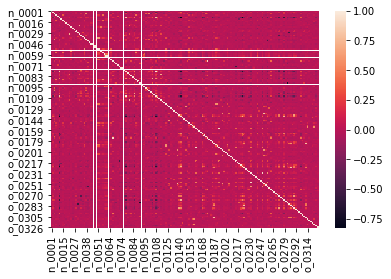

In [299]:
corr = X_train[continous_features_list].corr(method='pearson')
sns.heatmap(corr)
plt.show()

Корреляция невысокая между большей частью пар фичей. Но все таки есть заметный "квадратный минор" справа внизу на хитмапе, где кореляция высокая. Пространство, вообще говоря, сильно большое. Для отбора фичей обучим LogisticRegression с L1 регуляризацией, затем посмотрим на признаки без вклада в результат и выкинем их. А дальше обучим Baging модель с базовой моделю LR.

In [300]:
X_train[continous_features_list].head()

,n_0001,n_0002,n_0005,n_0006,n_0007,n_0012,n_0014,n_0015,n_0016,n_0017,n_0019,n_0020,n_0022,n_0025,n_0027,n_0028,n_0029,n_0030,n_0034,n_0035,n_0037,n_0038,n_0039,n_0041,n_0046,n_0047,n_0048,n_0050,n_0051,n_0052,n_0054,n_0057,n_0059,n_0060,n_0061,n_0064,n_0066,n_0067,n_0068,n_0069,...,o_0232,o_0235,o_0236,o_0241,o_0245,o_0247,o_0248,o_0251,o_0252,o_0256,o_0260,o_0264,o_0265,o_0268,o_0269,o_0270,o_0274,o_0276,o_0278,o_0279,o_0280,o_0281,o_0282,o_0283,o_0285,o_0286,o_0292,o_0293,o_0296,o_0301,o_0304,o_0305,o_0312,o_0314,o_0315,o_0316,o_0319,o_0323,o_0324,o_0326
735,0.702381,0.051440,0.394737,0.2,0.0,0.170732,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.254545,0.185185,0.164179,0.125,0.0025,0.209677,0.208333,0.090909,0.418605,1,0.727273,1,0.05,1,0.0,0.042553,0.0,0.0,1,0.0,0.081633,0.714286,0.259259,0.05,...,5.0,5.0,5.0,22.0,6.0,6.0,25.0,7.0,6.0,33.0,0.0,2,6.0,5.0,22.5,5.0,36.0,1.0,5.0,29.0,2.0,37.0,24.0,22.0,0.0,23.0,22.0,5.0,5.0,5.0,6.0,1.0,17.0,0.0,0.0,5.0,6.0,0.0,1.0,5.0
6825,0.809524,0.040827,0.473684,0.2,0.0,0.292683,0.0,0.000000,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.254545,0.185185,0.104478,0.125,0.0025,0.241935,0.208333,0.090909,0.418605,1,1.000000,1,0.05,1,0.0,0.000000,0.0,0.0,1,0.0,0.000000,0.357143,0.259259,0.05,...,5.0,5.0,5.0,22.0,6.0,6.0,25.0,7.0,6.0,33.0,0.0,4,6.0,5.0,22.5,10.0,37.0,1.0,5.0,40.0,2.0,37.0,24.0,22.0,1.0,18.0,24.0,5.0,5.0,5.0,11.0,1.0,17.0,0.0,0.0,5.0,6.0,0.0,1.0,5.0
84,0.702381,0.052740,0.421053,0.2,0.0,0.109756,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.254545,0.185185,0.164179,0.125,0.0025,0.241935,0.166667,0.090909,0.418605,1,0.727273,1,0.05,1,0.0,0.042553,0.0,0.0,1,0.0,0.081633,0.571429,0.259259,0.05,...,5.0,5.0,5.0,22.0,6.0,6.0,29.0,10.0,6.0,39.0,0.0,6,6.0,4.0,22.5,0.0,36.0,1.0,11.0,36.0,2.0,37.0,24.0,22.0,1.0,23.0,22.0,5.0,6.0,8.0,6.0,1.0,17.0,0.0,0.0,5.0,6.0,0.0,1.0,5.0
5557,0.702381,0.048841,0.289474,0.2,0.0,0.085366,0.0,0.014493,0.404762,0.472222,0.0,0.378378,0.0,0.006993,0.142857,0.045455,0.254545,0.129630,0.164179,0.125,0.0025,0.209677,0.270833,0.090909,0.418605,1,0.090909,1,0.05,1,0.0,0.042553,0.0,0.0,1,0.0,0.081633,0.000000,0.259259,0.05,...,5.0,8.0,5.0,22.0,9.0,6.0,27.0,7.0,6.0,36.0,0.0,1,1.0,3.0,22.5,5.0,36.0,0.0,4.0,30.0,2.0,37.0,24.0,22.0,1.0,23.0,22.0,6.0,1.0,0.0,6.0,1.0,17.0,0.0,0.0,5.0,8.0,0.0,1.0,5.0
703,0.702381,0.039853,0.394737,0.2,0.0,0.195122,0.0,0.014493,0.404762,0.472222,0.0,0.405405,0.0,0.006993,0.142857,0.045455,0.254545,0.185185,0.164179,0.125,0.0025,0.225806,0.208333,0.090909,0.418605,1,0.727273,1,0.05,1,0.0,0.042553,0.0,0.0,1,0.0,0.081633,0.714286,0.259259,0.05,...,5.0,5.0,5.0,15.0,6.0,6.0,25.0,7.0,6.0,33.0,0.0,7,6.0,9.0,22.5,1.0,36.0,1.0,5.0,27.0,2.0,37.0,24.0,22.0,1.0,23.0,22.0,5.0,5.0,10.0,6.0,1.0,17.0,0.0,0.0,5.0,6.0,0.0,1.0,5.0


In [301]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
filtered_cols = X_train[continous_features_list].columns[columns]
selected_columns = list(set(categorical_features_list) | set(filtered_cols))
len(selected_columns)

685

In [302]:
X_train =  X_train[selected_columns].values
X_val = X_val[selected_columns].values

In [303]:
y_train = y_train.values
y_val = y_val.values

In [304]:
X_train.shape

(6000, 685)

In [305]:
X_test = test_data[selected_columns].values
X_test.shape

(2000, 685)

Еще одна проблема, которую надо изучить - несбалансированность классов. Проверим.

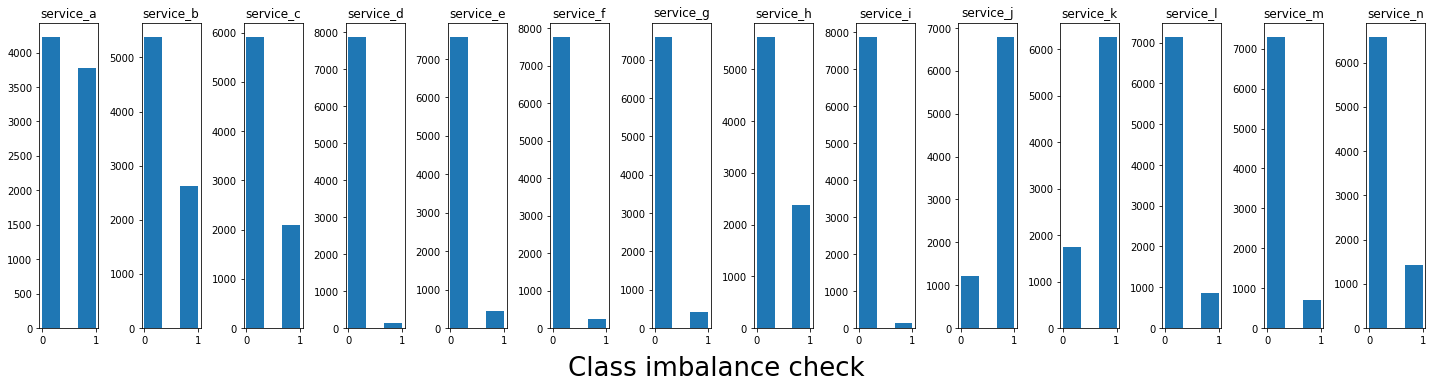

In [306]:
fig, axes = plt.subplots(1, 14, figsize=(20, 5), tight_layout=True)
fig.suptitle('Class imbalance check', ha='center', fontsize=26, y=0)
for i, col in enumerate(train_labels.columns):
  axes[i].hist(train_labels[col], bins=3)
  axes[i].set_title(col, fontsize=12)
plt.show()

Видим, что у многих классов есть проблема несбалансированности. Попробую решить это  oversampling-ом. Но сначало посмотрим, будет ли существенная разница, если выкинуть выборочно некоторые объекты, приводящие к имбалансу.

In [307]:
indexes_imb = train_labels.index[ (train_labels['service_a'] == 0) &
                      (train_labels['service_b'] == 0) &
                      (train_labels['service_c'] == 0) &
                      (train_labels['service_d'] == 0) &
                      (train_labels['service_e'] == 0) &
                      (train_labels['service_f'] == 0) &
                      (train_labels['service_g'] == 0) &
                      (train_labels['service_h'] == 0) &
                      (train_labels['service_i'] == 0) &
                      (train_labels['service_j'] == 1) &
                      (train_labels['service_k'] == 1) &
                      (train_labels['service_l'] == 0) &
                      (train_labels['service_m'] == 0) &
                      (train_labels['service_n'] == 0) ].tolist()
len(indexes_imb)

1807

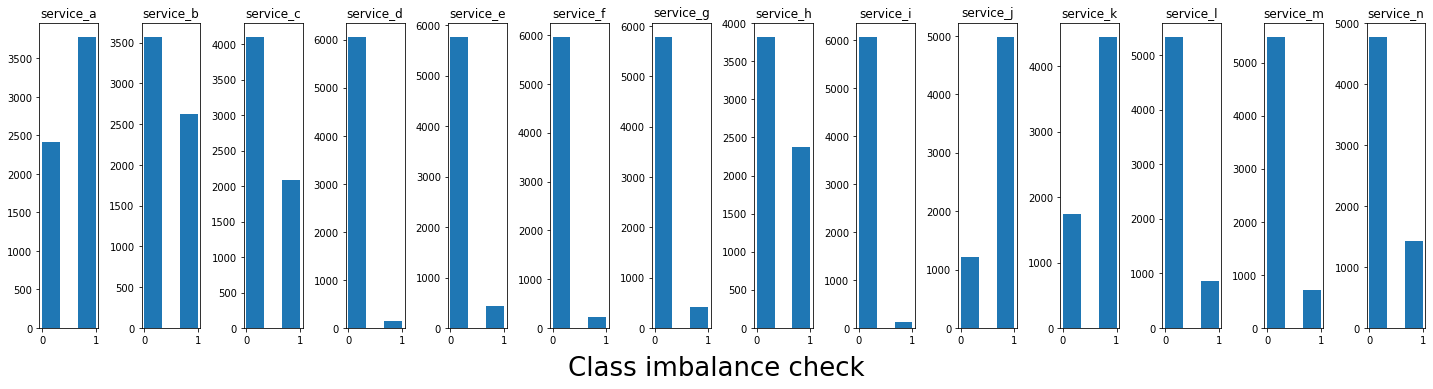

In [308]:
dropped_data_labels = train_labels.drop(indexes_imb)

fig, axes = plt.subplots(1, 14, figsize=(20, 5), tight_layout=True)
fig.suptitle('Class imbalance check', ha='center', fontsize=26, y=0)
for i, col in enumerate(dropped_data_labels.columns):
  axes[i].hist(dropped_data_labels[col], bins=3)
  axes[i].set_title(col, fontsize=12)
plt.show()

Любопытно также смотреть, насколько коррелируют классы между собой.

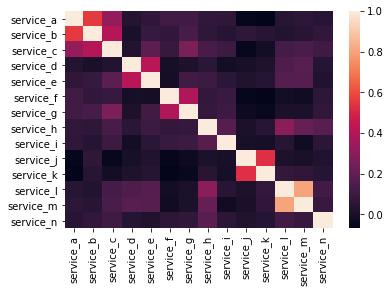

In [309]:
corr = train_labels.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [310]:
sp.stats.spearmanr(train_labels['service_k'], train_labels['service_j'])

SpearmanrResult(correlation=0.5335907040909952, pvalue=0.0)

Матрица корреляций показывает, что попарная скоррелированность есть только у $(service_a, service_b), (service_m, service_l), (service_j, service_k)$. Остальные не коррелируют. В таком случае вероятно, что отдельные классификаторы для каждого класса вполне могут хорошо предсказать.

# Модели


Функции для обучения/тестирования моделей:

In [247]:
from sklearn.model_selection import KFold
from IPython.display import clear_output

def train_cv(model, X_train, y_train, n_splits=4, chain=False, batch_size=512):
  kfold = KFold(n_splits=n_splits, shuffle=True)
  accuracies = []
  losses = []
  f1_scores = []
  precisions = []
  recalls = []
  train_loss = []
  clf = None
  if chain:
    clf = ClassifierChain(model, order='random', random_state=0)
  else:
    clf = MultiOutputClassifier(model)
  for i, (train_idx, test_idx) in enumerate(kfold.split(X_train)):
    train_dataset = TensorDataset( Tensor(X_train[train_idx]), Tensor(y_train[train_idx]) )
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
    loss_avg = 0
    accuracy_avg = 0
    f1_avg = 0
    precision_avg = 0
    for j, (x_batch, y_batch) in enumerate(iter(train_data_loader)):
      
      clf.fit(x_batch, y_batch)
      y_prob_train = clf.predict_proba(x_batch)
      train_loss_avg = np.mean(log_losses(y_batch, y_prob_train))

      y_pred = clf.predict(X_train[test_idx])
      y_proba = clf.predict_proba(X_train[test_idx])

      loss_avg = np.mean(log_losses(y_train[test_idx], y_proba))
      accuracy_avg = np.mean(accuracy_scores(y_train[test_idx], y_pred))
      f1_avg = f1_score(y_train[test_idx], y_pred, average='samples')
      recall_avg = np.mean(recall_score(y_train[test_idx], y_pred, average='samples'))
      precision_avg = np.mean(precision_score(y_train[test_idx], y_pred, average='samples'))
      
      losses.append(loss_avg)
      accuracies.append(accuracy_avg)
      f1_scores.append(f1_avg)
      recalls.append(recall_avg)
      precisions.append(precision_avg)
      train_loss.append(train_loss_avg)

    print("Fold %d:" % i)
    print("Average loss: %f" % loss_avg)
    print("Average train loss: %f" % train_loss_avg)
    print("Average accuracy: %f" % accuracy_avg)
    print("Average f1-score: %f" % f1_avg)
    print("Average recall: %f" % recall_avg)
    print("Average precision: %f" % precision_avg)
    print()
    
    losses.append(loss_avg)
    accuracies.append(accuracy_avg)
    f1_scores.append(f1_avg)
    recalls.append(recall_avg)
    precisions.append(precision_avg)

  
  return clf, (losses, accuracies, f1_scores, recalls, precisions)

In [248]:
def accuracy_scores(y_true, y_pred):
  
  return [accuracy_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]

def log_losses(y_true, y_proba):
  if (len(y_proba) == len(y_true) and len(y_proba[0]) == len(y_proba[0])):
    return [log_loss(y_true[:,i], y_proba[:,i], eps=0.001) for i in range(y_proba.shape[1])]
  
  return [log_loss(y_true[:,i], y_proba[i], eps=0.001) for i in range(len(y_proba))]


def multi_output_classifier_train(single_output_classifier, X_train, y_train):
  clf = MultiOutputClassifier(single_output_classifier).fit(X_train, y_train)
  
  return clf


def plot_roc_curve_multi(clf, X_val, y_val):

  fig = plt.figure(figsize=(12, 8))
  y_proba = clf.predict_proba(X_val)
  if(len(np.array(y_proba).shape) > 2):
    y_proba = np.array(y_proba)[:,:,1].T


  for i in range(14):
    fpr, tpr, _ = roc_curve(y_val[:,i],  y_proba[:,i])
    auc = roc_auc_score(y_val[:,i], y_proba[:,i])
    plt.plot(fpr, tpr, label="{}, AUC={:.3f}".format(i, auc))
      
  plt.plot([0,1], [0,1], color='orange', linestyle='--')

  plt.xticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlabel("False Positive Rate", fontsize=15)

  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.ylabel("True Positive Rate", fontsize=15)

  plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
  plt.legend(prop={'size':13}, loc='lower right')

  plt.show()

def test(clf, X_val, y_val):
  
  y_pred = clf.predict(X_val)
  y_proba = clf.predict_proba(X_val)

  loss_avg = np.mean(log_losses(y_val, y_proba))
  accuracy_avg = np.mean(accuracy_scores(y_val, y_pred))
  f1_avg = f1_score(y_val, y_pred, average='samples')
  recall_avg = np.mean(recall_score(y_val, y_pred, average='samples'))
  precision_avg = np.mean(precision_score(y_val, y_pred, average='samples'))
     
  print("Average loss: %f" % loss_avg)
  print("Average accuracy: %f" % accuracy_avg)
  print("Average f1-score: %f" % f1_avg)
  print("Average recall: %f" % recall_avg)
  print("Average precision: %f" % precision_avg)
  
  plot_roc_curve_multi(clf, X_val, y_val)

  return y_pred, y_proba


# Bagging

Лучшая модель, что получилась - это сбалансирующий bagging ensemble логистических регрессий. Эта модель хорошо справляется с имбалансом, генерируя синтетические объекты по стратегии "из класса, который уступает по количеству". Лучшие параметры найдены random search-ом  и зафиксированы уже для удобства.

Обучим обычную логрегрессию с l1 регуляризацией.

In [249]:
warnings.filterwarnings('ignore')

lr_params = {
    'random_state': 0,
    'penalty': 'elasticnet',
    'max_iter': 200,
    'C': 1e-2,
    'solver': 'saga',
    'l1_ratio': 0.7
}

clf = LogisticRegression(**lr_params)
lr_model, lr_metrics = train_cv(clf, X_train, y_train, batch_size=6000)

Fold 0:
Average loss: 0.296538
Average train loss: 0.284087
Average accuracy: 0.870857
Average f1-score: 0.717268
Average recall: 0.711136
Average precision: 0.803498

Fold 1:
Average loss: 0.293887
Average train loss: 0.286045
Average accuracy: 0.872286
Average f1-score: 0.724807
Average recall: 0.707155
Average precision: 0.822511

Fold 2:
Average loss: 0.293937
Average train loss: 0.285055
Average accuracy: 0.872619
Average f1-score: 0.718364
Average recall: 0.716865
Average precision: 0.799272

Fold 3:
Average loss: 0.298291
Average train loss: 0.284368
Average accuracy: 0.870238
Average f1-score: 0.722986
Average recall: 0.711025
Average precision: 0.811502



Average loss: 0.305227
Average accuracy: 0.866821
Average f1-score: 0.705697
Average recall: 0.694495
Average precision: 0.796251


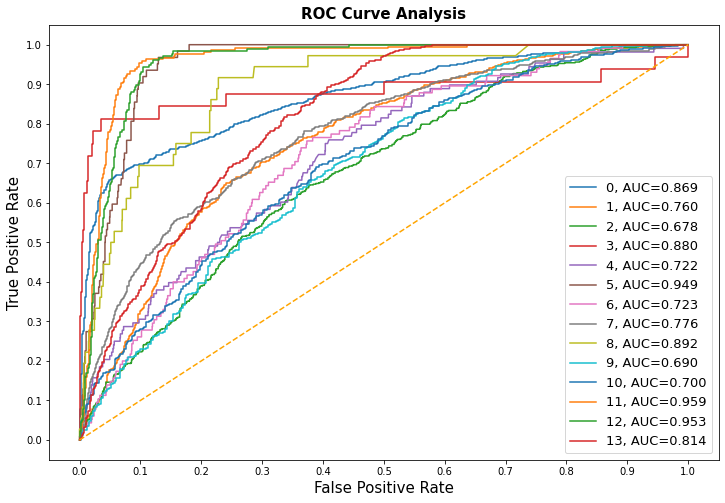

In [250]:
y_pred, y_proba = test(lr_model, X_val, y_val)

Отберем фичи с нулевыми коэффициентами. И проверим кореляционную матрицу.

In [251]:
features_with_impact = set()
for i in range(len(lr_model.estimators_)):
  features_with_impact |= set(np.where(lr_model.estimators_[i].coef_ != 0)[1])
features_with_impact = list(features_with_impact)
X_train_new = np.array(X_train)[:, features_with_impact]
X_val_new = X_val[:, features_with_impact]
X_train_new.shape

(6000, 205)

In [271]:
X_test_new = X_test[:, features_with_impact]

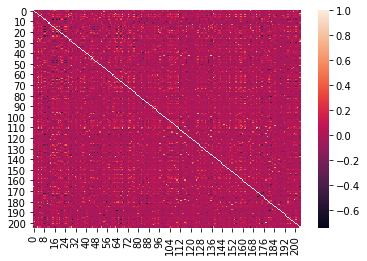

In [253]:
df_new = pd.DataFrame(X_train_new)
corr_new = df_new.corr()
sns.heatmap(corr_new)
plt.show()

Посмотрим как отбор повлияет на результат logreg-a.

In [254]:
warnings.filterwarnings('ignore')

lr_params = {
    'random_state': 0,
    'penalty': 'elasticnet',
    'max_iter': 100,
    'C': 1e-2,
    'solver': 'saga',
    'l1_ratio': 0.7
}

clf = LogisticRegression(**lr_params)
lr_model_new, lr_metrics_new = train_cv(clf, X_train_new, y_train, batch_size=6000)

Fold 0:
Average loss: 0.294714
Average train loss: 0.286888
Average accuracy: 0.871286
Average f1-score: 0.712714
Average recall: 0.712158
Average precision: 0.786505

Fold 1:
Average loss: 0.297330
Average train loss: 0.285398
Average accuracy: 0.871476
Average f1-score: 0.713615
Average recall: 0.707349
Average precision: 0.801133

Fold 2:
Average loss: 0.305078
Average train loss: 0.284116
Average accuracy: 0.864810
Average f1-score: 0.717280
Average recall: 0.697047
Average precision: 0.824261

Fold 3:
Average loss: 0.289688
Average train loss: 0.288591
Average accuracy: 0.876381
Average f1-score: 0.734694
Average recall: 0.722461
Average precision: 0.823541



Average loss: 0.306823
Average accuracy: 0.866143
Average f1-score: 0.703298
Average recall: 0.692515
Average precision: 0.793699


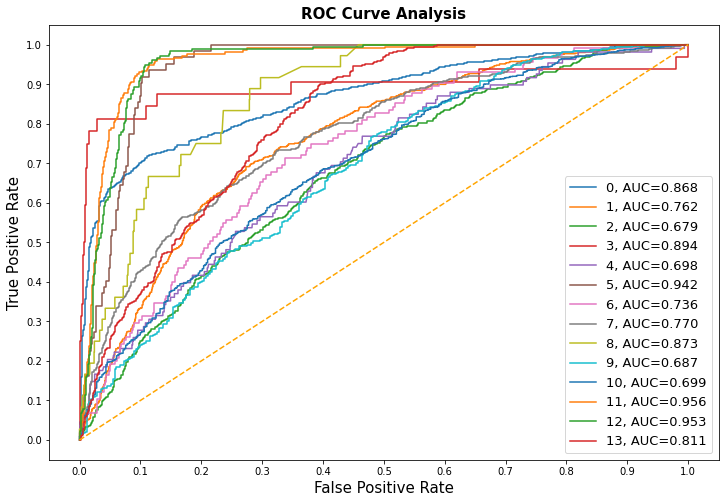

In [255]:
y_pred_new, y_proba_new = test(lr_model_new, X_val_new, y_val)

Теперь уже на отобранном пространстве обучим Bagging.

In [256]:
X_train.shape, y_train.shape

((6000, 685), (6000, 14))

In [257]:
warnings.filterwarnings('ignore')

lr_params = {
    'random_state': 0,
    'penalty': 'elasticnet',
    'max_iter': 200,
    'C': 1e-2,
    'solver': 'saga',
    'l1_ratio': 0.7
}

lr = LogisticRegression(**lr_params)

bbc_lr = BalancedBaggingClassifier(base_estimator=lr,
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=0)


bbc_lr_model, bbc_lr_metrix = train_cv(bbc_lr, 
                                      X_train_new, 
                                      y_train, 
                                      batch_size=6000, 
                                      n_splits=4)


Fold 0:
Average loss: 0.293898
Average train loss: 0.282223
Average accuracy: 0.872952
Average f1-score: 0.713475
Average recall: 0.711879
Average precision: 0.793140

Fold 1:
Average loss: 0.296256
Average train loss: 0.282641
Average accuracy: 0.869143
Average f1-score: 0.721225
Average recall: 0.718512
Average precision: 0.806044

Fold 2:
Average loss: 0.290138
Average train loss: 0.283938
Average accuracy: 0.874857
Average f1-score: 0.727216
Average recall: 0.710345
Average precision: 0.818615

Fold 3:
Average loss: 0.298792
Average train loss: 0.280675
Average accuracy: 0.869429
Average f1-score: 0.722997
Average recall: 0.711268
Average precision: 0.816711



Average loss: 0.304864
Average accuracy: 0.867321
Average f1-score: 0.706791
Average recall: 0.697059
Average precision: 0.795785


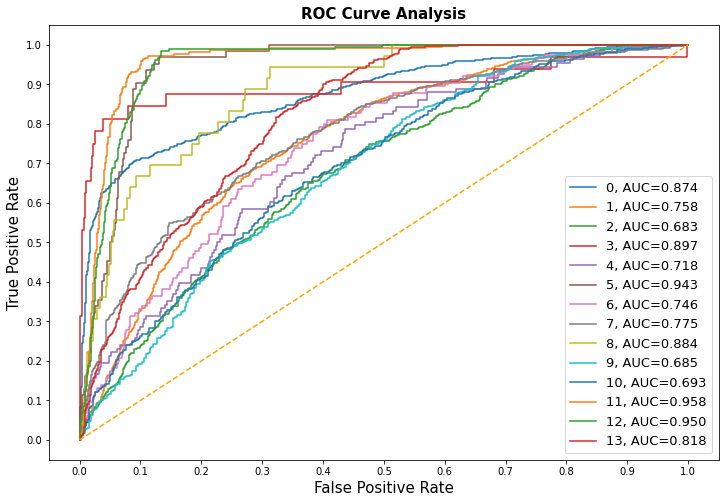

In [259]:
y_pred, y_proba = test(bbc_lr_model, X_val_new, y_val)

In [272]:
y_pred = bbc_lr_model.predict(X_test_new)
y_proba = np.array(bbc_lr_model.predict_proba(X_test_new))
result = y_proba[:,:,1]
result = result.T

In [273]:
df_result = pd.DataFrame(result)
df_result.to_csv(test_labels_path)

**Bagging of boosting**

Также ниже есть эксперименты с другими моделями - xgboost

In [260]:
# тут сохранены лучшие параметры, подобранные grid_search-ом
xbst_best_params = {
    'colsamplebytree': 0.75,
    'gamma': 0,
    'learning_rate': 0.02,
    'max_depth': 6, 
    'min_child_weight': 1, 
    'n_estimators': 100,
    'num_class': 2, 
    'objective': 'multi:softprob',
    'random_state':0, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'subsample':0.75, 
}

xgb_clf = xgb.XGBClassifier(**xbst_best_params)
xgb_model, xgb_metrics = train_cv(xgb_clf, X_train, y_train, batch_size=6000)

Fold 0:
Average loss: 0.289545
Average train loss: 0.235777
Average accuracy: 0.888857
Average f1-score: 0.755843
Average recall: 0.762209
Average precision: 0.812154

Fold 1:
Average loss: 0.291229
Average train loss: 0.236066
Average accuracy: 0.887952
Average f1-score: 0.755354
Average recall: 0.764493
Average precision: 0.815457

Fold 2:
Average loss: 0.294311
Average train loss: 0.234085
Average accuracy: 0.886000
Average f1-score: 0.756952
Average recall: 0.763914
Average precision: 0.814111

Fold 3:
Average loss: 0.292595
Average train loss: 0.234813
Average accuracy: 0.887143
Average f1-score: 0.757239
Average recall: 0.753750
Average precision: 0.822335



Average loss: 0.300859
Average accuracy: 0.879286
Average f1-score: 0.735476
Average recall: 0.738474
Average precision: 0.798467


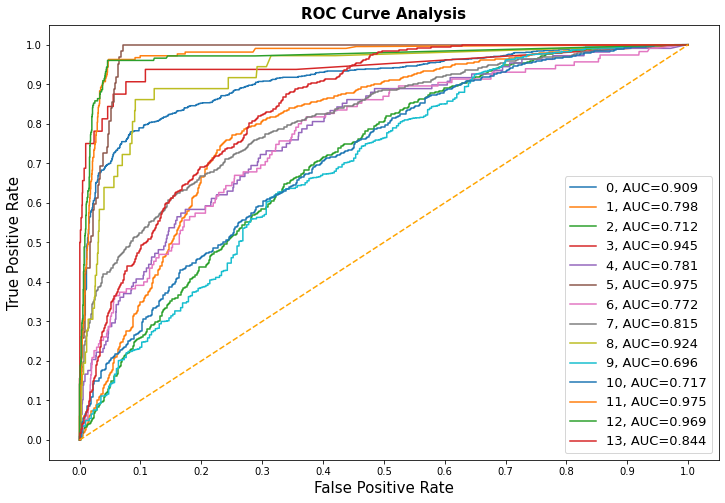

In [262]:
y_pred, y_proba = test(xgb_model, X_val, y_val)

Отберем важные признаки:

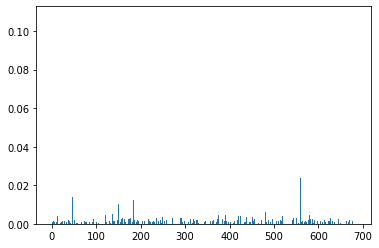

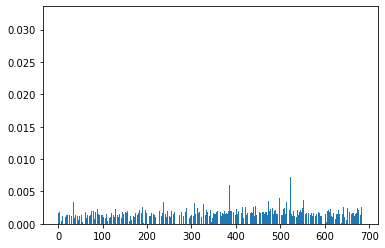

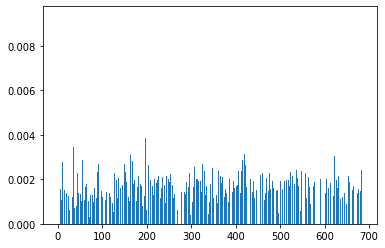

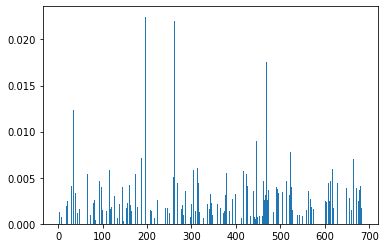

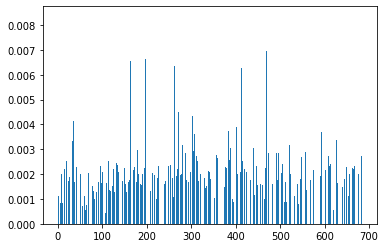

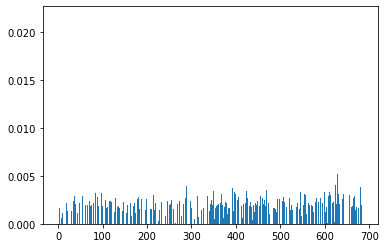

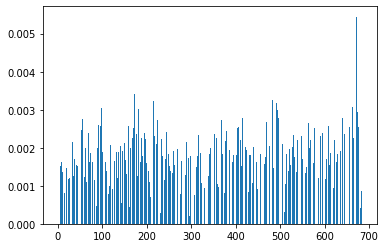

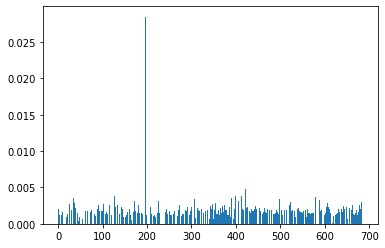

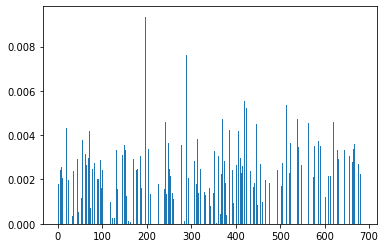

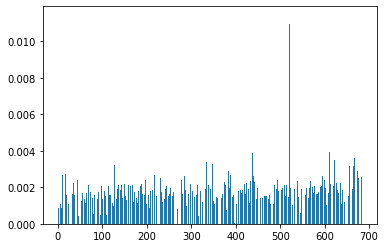

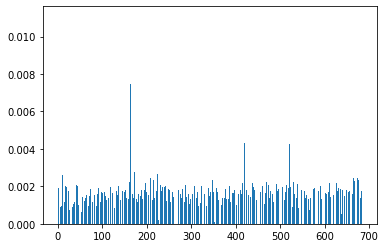

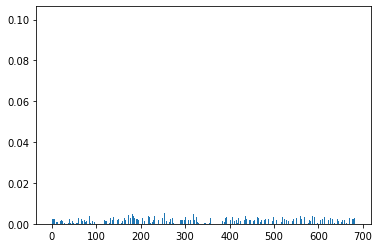

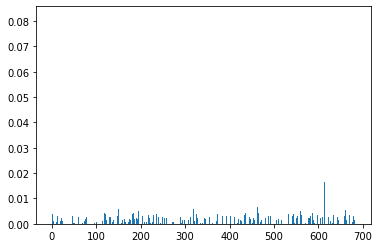

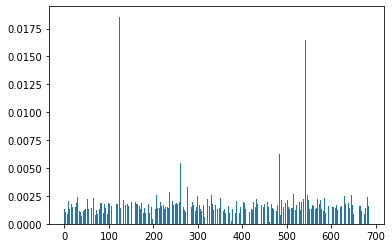

664


In [263]:
features_with_impact_xgb = set()
for i in range(len(xgb_model.estimators_)):
  importance = xgb_model.estimators_[i].feature_importances_

  # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  features_with_impact_xgb = features_with_impact_xgb | set([x for x in range(len(importance)) if importance[x] > 0 ])
  
  plt.show()
print( len(list(features_with_impact_xgb)))

In [274]:
features_with_impact_xgb = list(features_with_impact_xgb)
X_train_xgb = np.array(X_train)[:, features_with_impact_xgb]
X_val_xgb = X_val[:, features_with_impact_xgb]
X_test_xgb = X_test[:, features_with_impact_xgb]

Проверка, что качество модели не ухудшилось из-за отбора признаков.

In [265]:
# тут сохранены лучшие параметры, подобранные grid_search-ом
xbst_best_params = {
    'colsamplebytree': 0.75,
    'gamma': 0,
    'learning_rate': 0.02,
    'max_depth': 6, 
    'min_child_weight': 1, 
    'n_estimators': 100,
    'num_class': 2, 
    'objective': 'multi:softprob',
    'random_state':0, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'subsample':0.75, 
}

xgb_clf = xgb.XGBClassifier(**xbst_best_params)
xgb_model, xgb_metrics = train_cv(xgb_clf, X_train_xgb, y_train)

Fold 0:
Average loss: 0.313293
Average train loss: 0.146785
Average accuracy: 0.872952
Average f1-score: 0.728775
Average recall: 0.740313
Average precision: 0.788439

Fold 1:
Average loss: 0.305398
Average train loss: 0.151680
Average accuracy: 0.878476
Average f1-score: 0.744203
Average recall: 0.760900
Average precision: 0.794321

Fold 2:
Average loss: 0.306395
Average train loss: 0.149476
Average accuracy: 0.879429
Average f1-score: 0.751634
Average recall: 0.770823
Average precision: 0.796344

Fold 3:
Average loss: 0.313837
Average train loss: 0.146595
Average accuracy: 0.872619
Average f1-score: 0.735656
Average recall: 0.746231
Average precision: 0.795680



Average loss: 0.321289
Average accuracy: 0.868679
Average f1-score: 0.720418
Average recall: 0.733141
Average precision: 0.780504


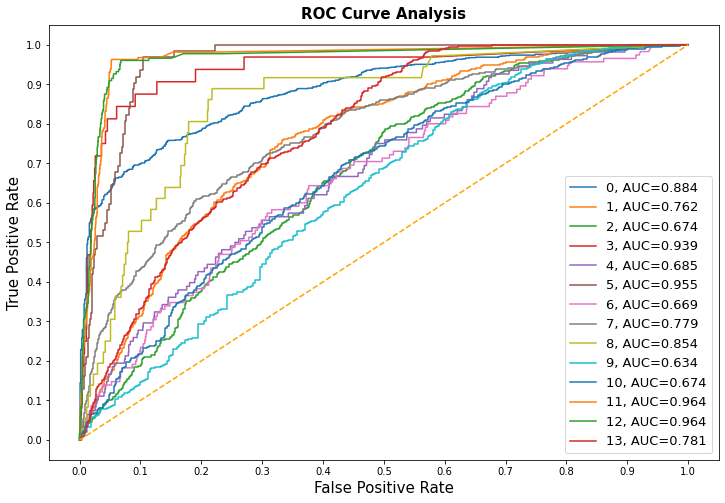

In [266]:
y_pred, y_proba = test(xgb_model, X_val_xgb, y_val)

Теперь обернем в bagging с sampling-ом (имбаланс классов).

In [ ]:
warnings.filterwarnings('ignore')

xbst_best_params = {
    'colsamplebytree': 0.75,
    'gamma': 0,
    'learning_rate': 0.02,
    'max_depth': 6, 
    'min_child_weight': 1, 
    'n_estimators': 100,
    'num_class': 2, 
    'objective': 'multi:softprob',
    'random_state':0, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'subsample':0.75, 
}


xgb_clf = xgb.XGBClassifier(**xbst_best_params)

bbc_lr_new = BalancedBaggingClassifier(base_estimator=xgb_clf,
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=0)


bbc_lr_model_new, bbc_lr_metrix_new = train_cv(bbc_lr_new, 
                                      X_train_new, 
                                      y_train, 
                                      batch_size=6000, 
                                      n_splits=3)


Fold 0:
Average loss: 0.297815
Average train loss: 0.242825
Average accuracy: 0.884107
Average f1-score: 0.746425
Average recall: 0.747895
Average precision: 0.810430

Fold 1:
Average loss: 0.292094
Average train loss: 0.244736
Average accuracy: 0.886714
Average f1-score: 0.755220
Average recall: 0.764898
Average precision: 0.808972

Fold 2:
Average loss: 0.291602
Average train loss: 0.244685
Average accuracy: 0.888750
Average f1-score: 0.759510
Average recall: 0.762510
Average precision: 0.818502



Average loss: 0.302096
Average accuracy: 0.881179
Average f1-score: 0.742186
Average recall: 0.744639
Average precision: 0.804624


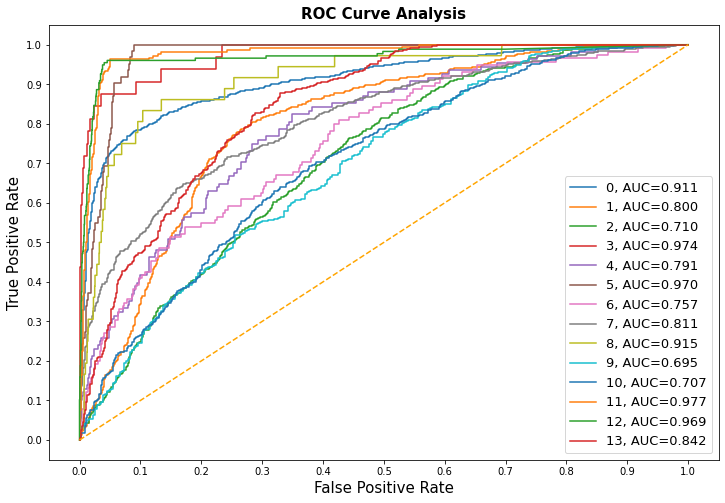

In [ ]:
dy_pred, dy_proba = test(bbc_lr_model_new, X_val_new, y_val)

In [ ]:
y_pred = bbc_lr_model.predict(X_test_new)
y_proba = np.array(bbc_lr_model.predict_proba(X_test_new))
result = y_proba[:,:,1]
result = result.T

In [ ]:
df_result = pd.DataFrame(result)
df_result.to_csv(test_labels_path)


**Random Forests**

In [311]:
random_forest = RandomForestClassifier(random_state=0)
model_forest = train_cv(random_forest, X_train, y_train)

Fold 0:
Average loss: 0.312495
Average train loss: 0.086558
Average accuracy: 0.865810
Average f1-score: 0.703377
Average recall: 0.675800
Average precision: 0.821156

Fold 1:
Average loss: 0.323881
Average train loss: 0.080061
Average accuracy: 0.858667
Average f1-score: 0.692606
Average recall: 0.666115
Average precision: 0.811592

Fold 2:
Average loss: 0.310865
Average train loss: 0.083015
Average accuracy: 0.865190
Average f1-score: 0.699936
Average recall: 0.671418
Average precision: 0.821800

Fold 3:
Average loss: 0.309672
Average train loss: 0.086433
Average accuracy: 0.866000
Average f1-score: 0.700174
Average recall: 0.686997
Average precision: 0.805333



Average loss: 0.315571
Average accuracy: 0.863893
Average f1-score: 0.699361
Average recall: 0.683997
Average precision: 0.802775


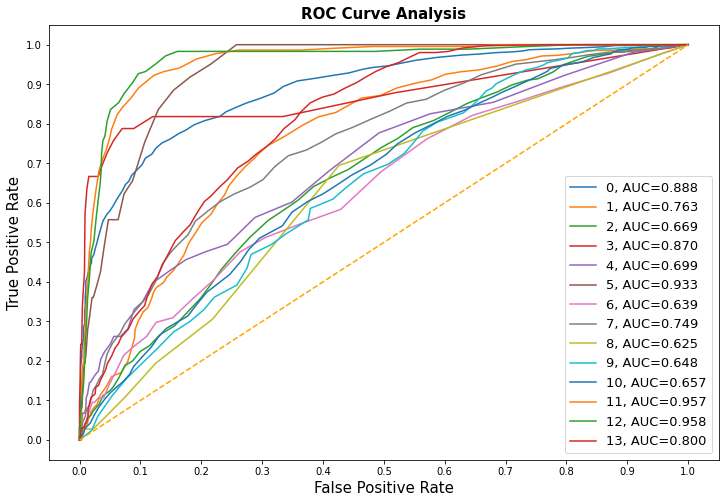

In [312]:
y_pred, y_proba = test(model_forest[0], X_val, y_val)

# 2 подход
Проверим как работает на LabelPowerset на нашем датасете. То есть каждый возможный вектор из 14-и классов кодируется как отдельный метакласс и обучается модель обычной классификации.

In [ ]:
X_train.shape

(6000, 1378)

In [ ]:
classifier = LabelPowerset(DecisionTreeClassifier(max_depth=10, random_state=0))
classifier.fit(X_train_pca, y_train)
y_pred = classifier.predict(X_val_pca)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = classifier.predict(X_val_pca).toarray()
y_proba = classifier.predict_proba(X_val_pca).toarray()

In [ ]:
loss_avg = np.mean([log_loss(y_val[:,i], y_proba[:,i]) for i in range(y_proba.shape[1])])
accuracy_avg = np.mean(accuracy_scores(y_val, y_pred))
f1_avg = f1_score(y_val, y_pred, average='samples')

print("Average f1-score: %f" % f1_avg)
print("Average loss: %f" % loss_avg)
print("Average accuracy: %f" % accuracy_avg)

Average f1-score: 0.624992
Average loss: 1.716728
Average accuracy: 0.831071


Ожидаемо высокий loss, так как в тесте появляются новые комбинации классов, которых модель не видел, также проблема парадокса accuracy возникла.

Еще один важный вариант, который довольно неплохо работает, это цепочка классификаторов, обучающихся на датасете и результатах предыдущих. Построим цепочку из логистических регрессий и проверим это.

In [ ]:
from sklearn.multioutput import ClassifierChain

In [ ]:
chain = LogisticRegression(random_state=0, solver='liblinear', max_iter=200)
chain, metrics_chain = train_cv(chain, X_train_pca, y_train, chain=True)

Fold 0:
Average loss: 0.853616
Average train loss: 0.010338
Average accuracy: 0.754048
Average f1-score: 0.561373
Average recall: 0.663200
Average precision: 0.567544

Fold 1:
Average loss: 0.875787
Average train loss: 0.009918
Average accuracy: 0.751048
Average f1-score: 0.565700
Average recall: 0.659282
Average precision: 0.574743

Fold 2:
Average loss: 0.856465
Average train loss: 0.009679
Average accuracy: 0.755952
Average f1-score: 0.581981
Average recall: 0.673202
Average precision: 0.595141

Fold 3:
Average loss: 0.869089
Average train loss: 0.010069
Average accuracy: 0.752476
Average f1-score: 0.573090
Average recall: 0.663646
Average precision: 0.585597



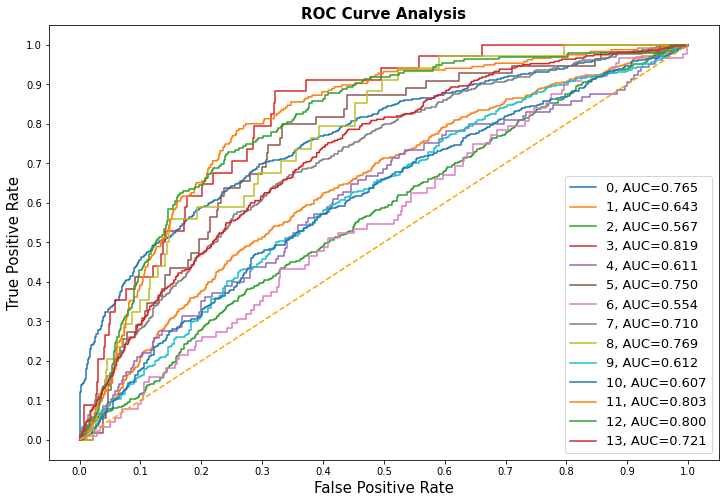

In [ ]:
y_pred = chain.predict(X_val_pca)
y_proba = chain.predict_proba(X_val_pca)
plot_roc_curve_multi(chain, X_val_pca, y_val)

In [ ]:
loss_avg = np.mean([log_loss(y_val[:,i], y_proba[:,i]) for i in range(y_proba.shape[1])])
accuracy_avg = np.mean(accuracy_scores(y_val, y_pred))
f1_avg = f1_score(y_val, y_pred, average='samples')

print("Average f1-score: %f" % f1_avg)
print("Average loss: %f" % loss_avg)
print("Average accuracy: %f" % accuracy_avg)

Average f1-score: 0.566914
Average loss: 0.963829
Average accuracy: 0.759000


# DL

In [ ]:
X_train.shape

(6000, 1378)

In [ ]:
pca = PCA(0.999)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.999, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

X, y = X_train_pca, y_train
X.shape, y.shape

((6000, 1062), (6000, 14))

In [ ]:
X.shape, y.shape

((6000, 1062), (6000, 14))

In [ ]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU, Sigmoid, LSTM, Dropout, Module, GRU, BatchNorm1d
from sklearn.model_selection import KFold
import torch.optim as optim


class Reshape(nn.Module): 
  def __init__(self, *args): 
    
    super(Reshape, self).__init__() 
    self.shape = args 

  def forward(self, x): 
    
    if(self.shape[0] == 1 and len(self.shape) == 3 and self.shape[1] * self.shape[2] != x.shape[0] * x.shape[1]):
      return  x.view((self.shape[0], (x.shape[0] * x.shape[1]) // self.shape[2], self.shape[2]))

    return x.view(self.shape) 

In [ ]:
BATCH_SIZE=400
net_LSTM = Sequential(
    Linear(X.shape[1], 512),
    ReLU(),
    BatchNorm1d(512),
    Linear(512, BATCH_SIZE),
    ReLU(),
    Dropout(),
    Reshape(1, BATCH_SIZE, BATCH_SIZE),
    flightLSTM(BATCH_SIZE, 128, 1),
    Reshape(-1, 128),
    ReLU(),
    Dropout(),
    Linear(128, 64),
    ReLU(),
    Dropout(),
    Linear(64, train_labels.shape[1]),
    Sigmoid()
)

net_linear = Sequential(
    Linear(X.shape[1], 256),
    ReLU(),
    BatchNorm1d(256),
    Linear(256, 128),
    ReLU(),
    Dropout(),
    Linear(128, 64),
    ReLU(),
    Dropout(),
    Linear(64, train_labels.shape[1]),
    Sigmoid()
)
net_linear

Sequential(
  (0): Linear(in_features=1062, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=14, bias=True)
  (10): Sigmoid()
)

In [ ]:
criterion_linear = torch.nn.MSELoss()
optimizer_linear = optim.Adam(net_linear.parameters(), lr=0.001)

criterion_lstm = torch.nn.MSELoss()
optimizer_lstm = optim.Adam(net_LSTM.parameters(), lr=0.001)

In [ ]:
def probs_to_label(prob):
  return 1. if prob > 0.5 else 0.;

probs_to_label_vectorized = np.vectorize(probs_to_label)

def evaluate_model(model, X, y, criterion, optimizer, n_splits=5, batch_size=BATCH_SIZE, epochs=40):
  results = []

  n_inputs, n_outputs = X.shape[1], y.shape[1]
  kfold = KFold(n_splits=n_splits, shuffle=True)
  accuracies = []
  losses = []
  f1_scores = []
  precisions = []
  recalls = []
  X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
  for i, (train_ix, test_ix) in enumerate(kfold.split(X)):

    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    dataset = TensorDataset( Tensor(X_train), Tensor(y_train) )
    data_loader = DataLoader(dataset, batch_size=batch_size)

    model.train()
    for epoch in range(epochs):
      for j, (x_batch, y_batch) in enumerate(iter(data_loader)):
        optimizer.zero_grad()

        outputs = model(x_batch)

        loss = criterion(outputs, y_batch)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    test_dataset = TensorDataset( Tensor(X_test), Tensor(y_test) )
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size)
    loss_avg = 0
    accuracy_avg = 0
    f1_avg = 0
    for j, (x_batch, y_batch) in enumerate(iter(test_data_loader)):

      y_prob = model(x_batch).detach().numpy()
      y_pred = probs_to_label_vectorized(y_prob)
      loss_avg = np.mean(log_losses(y_batch, y_pred))
      accuracy_avg = np.mean(accuracy_scores(y_batch, y_pred))
      f1_avg = f1_score(y_batch, y_pred, average='samples')
      recall_avg = np.mean(recall_score(y_batch, y_pred, average='samples'))
      precision_avg = np.mean(precision_score(y_batch, y_pred, average='samples'))
      
      losses.append(loss_avg)
      accuracies.append(accuracy_avg)
      f1_scores.append(f1_avg)
      recalls.append(recall_avg)
      precisions.append(precision_avg)
    
    print("Fold %d:" % i)
    print("Average loss: %f" % np.mean(loss_avg))
    print("Average accuracy: %f" % np.mean(accuracy_avg))
    print("Average f1-score: %f" % np.mean(f1_avg))
    print("Average recall: %f" % np.mean(recall_avg))
    print("Average precision: %f" % np.mean(precision_avg))
    


  fig, axs = plt.subplots(1, 3, figsize=(12, 8))
  fig.suptitle('Training')
  axs[0].plot(range(len(losses)), losses)
  axs[0].set_title('loss')
  axs[1].plot(range(len(accuracies)), accuracies)
  axs[1].set_title('accuracy')
  axs[2].plot(range(len(f1_scores)), f1_scores)
  axs[2].set_title('f1-score')
  return model, losses, accuracies, f1_scores

Fold 0:
Average loss: 0.992613
Average accuracy: 0.856429
Average f1-score: 0.709884
Average recall: 0.732686
Average precision: 0.773833
Fold 1:
Average loss: 0.382105
Average accuracy: 0.944821
Average f1-score: 0.868413
Average recall: 0.877332
Average precision: 0.893449
Fold 2:
Average loss: 0.216837
Average accuracy: 0.968750
Average f1-score: 0.927158
Average recall: 0.925601
Average precision: 0.948202
Fold 3:
Average loss: 0.176136
Average accuracy: 0.974643
Average f1-score: 0.942759
Average recall: 0.940150
Average precision: 0.959342
Fold 4:
Average loss: 0.110769
Average accuracy: 0.984107
Average f1-score: 0.964196
Average recall: 0.964682
Average precision: 0.971667


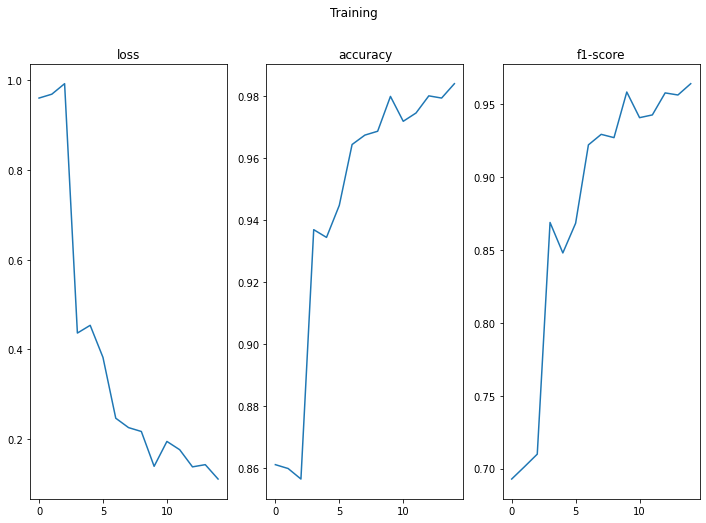

In [ ]:
net_linear, losses, accuracies, f1_scores = evaluate_model(net_linear, X, y, criterion_linear, optimizer_linear)

Fold 0:
Average loss: 0.949446
Average accuracy: 0.862679
Average f1-score: 0.694622
Average recall: 0.715780
Average precision: 0.752812
Fold 1:
Average loss: 0.520240
Average accuracy: 0.924821
Average f1-score: 0.839460
Average recall: 0.839494
Average precision: 0.877657
Fold 2:
Average loss: 0.285904
Average accuracy: 0.958750
Average f1-score: 0.906223
Average recall: 0.903642
Average precision: 0.930046
Fold 3:
Average loss: 0.229170
Average accuracy: 0.966964
Average f1-score: 0.916467
Average recall: 0.915650
Average precision: 0.935700
Fold 4:
Average loss: 0.216837
Average accuracy: 0.968750
Average f1-score: 0.933940
Average recall: 0.929126
Average precision: 0.958765


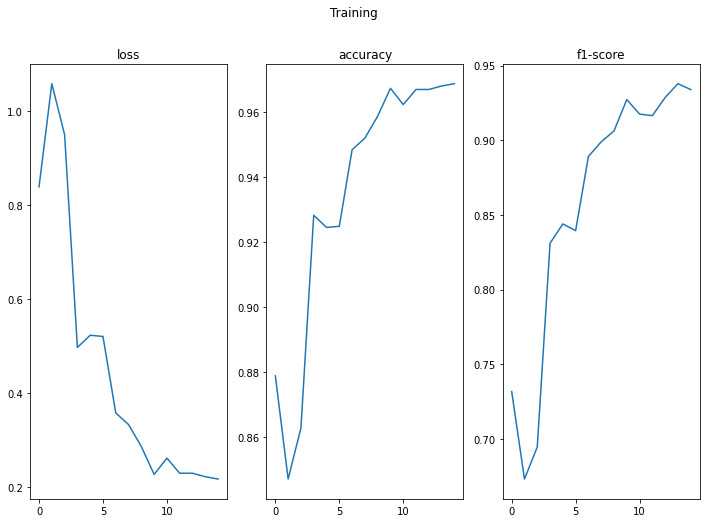

In [ ]:
net_LSTM, losses, accuracies, f1_scores = evaluate_model(net_LSTM, X, y, criterion_lstm, optimizer_lstm)

In [ ]:
net_linear.eval()
test_dataset = TensorDataset( Tensor(X_val_pca), Tensor(y_val) )
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
loss_avg = 0
accuracy_avg = 0
f1_avg = 0
losses=[]
accuracies=[]
f1_scores=[]
for j, (x_batch, y_batch) in enumerate(iter(test_data_loader)):
  y_prob = net_linear(x_batch).detach().numpy()
  y_pred = probs_to_label_vectorized(y_prob)
  loss_avg = log_losses(y_batch, y_pred)
  accuracy_avg = accuracy_scores(y_batch, y_pred)
  f1_avg = f1_score(y_batch, y_pred, average='samples')

  losses.append(loss_avg)
  accuracies.append(accuracy_avg)
  f1_scores.append(f1_avg)

print("Average loss: %f" % np.mean(losses))
print("Average accuracy: %f" % np.mean(accuracies))
print("Average f1-score: %f" % np.mean(f1_scores))


Average loss: 1.019007
Average accuracy: 0.852607
Average f1-score: 0.682221


In [ ]:
net_LSTM.eval()
test_dataset = TensorDataset( Tensor(X_val_pca), Tensor(y_val) )
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
loss_avg = 0
accuracy_avg = 0
f1_avg = 0
losses=[]
accuracies=[]
f1_scores=[]
for j, (x_batch, y_batch) in enumerate(iter(test_data_loader)):
  y_prob = net_LSTM(x_batch).detach().numpy()
  y_pred = probs_to_label_vectorized(y_prob)
  loss_avg = log_losses(y_batch, y_pred)
  accuracy_avg = accuracy_scores(y_batch, y_pred)
  f1_avg = f1_score(y_batch, y_pred, average='samples')

  losses.append(loss_avg)
  accuracies.append(accuracy_avg)
  f1_scores.append(f1_avg)

print("Average loss: %f" % np.mean(losses))
print("Average accuracy: %f" % np.mean(accuracies))
print("Average f1-score: %f" % np.mean(f1_scores))


Average loss: 0.975100
Average accuracy: 0.858964
Average f1-score: 0.698193


В целом я априори был настроен решить задачу через классические методы машинного обучения, так как их интерпретировать лучше получается нежели dl. Ну и dl дал гораздо хуже лосс, поэтому остановился на ML.